In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from timm.models.swin_transformer import SwinTransformer
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm, trange
from timm import create_model
from torchvision import transforms
from PIL import Image
from matplotlib import colors
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import DeepLabV3Plus, FPN
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import cv2


device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Current device: {device}')

Current device: mps


In [3]:
class TurtleDataset(Dataset):
    
    def __init__(self, data_dir, coco, mode='train', img_size=512):
        self.data_dir = data_dir
        self.coco = coco
        self.mode = mode
        self.img_size = img_size
        
        # Load image IDs for specific mode
        self.df_meta = pd.read_csv(
            os.path.join(data_dir, "metadata_splits.csv"),
            usecols=["id", "file_name", "split_open"]
        )
        self.img_ids = self.df_meta.query(f"split_open == '{mode}'")["id"].tolist()

        # transforms
        if mode == 'train':
            self.transform = A.Compose([
                A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.8,1)),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=img_size, width=img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # load image
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.data_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        # retrive annotations and create mask
        cat_ids = self.coco.getCatIds()
        anns_ids = self.coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(anns_ids)
    
        # Create combined mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for i in range(len(anns)):
            mask += self.coco.annToMask(anns[i])
    
        # Apply transforms
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask'].clone().detach()
    
        return image, mask, img_path


    def get_annotations(self, idx):
        
        img_id = self.img_ids[idx]
        anns_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(anns_ids)
        return anns(anns_ids)


In [4]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for images, masks, img_path in train_loader:
        images = images.to(device)
        masks = masks.to(device).long() 

        optimizer.zero_grad()
        outputs = model(images)
        

        # Calculate the loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    return epoch_loss / len(train_loader)


def calculate_iou(pred, target):
    ious = []
    classes = ['turtle', 'flipper', 'head']

    # IoU for each class
    for i in range(len(classes)):
        pred_class = (pred == i)
        target_class = (target == i)

        intersection = torch.logical_and(pred_class, target_class).sum()
        union = torch.logical_or(pred_class, target_class).sum()
        iou = (intersection.float() + 1e-6) / (union.float() + 1e-6)
        ious.append(iou.item())

    return np.mean(ious), ious

def validate(model, valid_loader, criterion, device):
    # validate use IOU
    model.eval()
    all_ious = []
    total_loss = 0
    
    with torch.no_grad():
        for images, masks,_ in valid_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks.long())
            total_loss += loss.item()
            
            # Calculate IoU
            _, preds = torch.max(outputs, 1)
            iou, _ = calculate_iou(preds, masks)
            all_ious.append(iou)

    mean_iou = np.mean(all_ious)
    mean_loss = total_loss / len(valid_loader)
    
    return mean_loss, mean_iou



## Option 1: Load saved weights

In [5]:
annotation_file = './turtles-data/data/annotations.json'
data_dir = './turtles-data/data/'
coco = COCO(annotation_file)

model_path = 'best_model_Deeplab_pretrained.pth'

# Check if the weight file
if os.path.isfile(model_path):
    model = DeepLabV3Plus(encoder_name='resnet50', encoder_weights=None, in_channels=3, classes=3)
    model = model.to(device)

    # Load the saved weights
    model.load_state_dict(torch.load(model_path))
    print("Model weights loaded successfully.")
else:
    print(f"No such file: '{model_path}' found. Please check the file path.")

test_dataset = TurtleDataset(data_dir=data_dir, coco=coco, mode='test', img_size=224)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


loading annotations into memory...
Done (t=1.65s)
creating index...
index created!
Model weights loaded successfully.


/var/folders/9c/4rwj9dzx4hb0ctgfxx2cgtcc0000gn/T/ipykernel_87376/2179520241.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

# Option2: Train model

In [ ]:
annotation_file = './turtles-data/data/annotations.json'
data_dir = './turtles-data/data/'
coco = COCO(annotation_file)

# Model init
model = DeepLabV3Plus(encoder_name='resnet50', encoder_weights='imagenet', in_channels=3, classes=3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)

# Early stopping setting
early_stopping_patience = 5  # acceptable number of epochs to wait
best_val_loss = float('inf')
epochs_without_improvement =0

train_dataset = TurtleDataset(data_dir=data_dir, coco=coco, mode='train', img_size=224)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

valid_dataset = TurtleDataset(data_dir=data_dir, coco=coco, mode='valid', img_size=224)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

test_dataset = TurtleDataset(data_dir=data_dir, coco=coco, mode='test', img_size=224)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training step
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Training Loss: {train_loss:.4f}")
    
    # Validation
    val_loss, val_iou = validate(model, valid_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Mean IoU: {val_iou:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset 
        # weight saving
        torch.save(model.state_dict(), 'best_model_Deeplab_pretrained.pth')
    else:
        epochs_without_improvement += 1
    
    # Check for early stopping
    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

loading annotations into memory...
Done (t=2.12s)
creating index...
index created!
Epoch 1/50


In [35]:
import numpy as np
import torch

def evaluate_test_set(model, test_loader, device):
    model.eval()
    total_loss = 0
    iou_scores = {'turtle': [], 'flipper': [], 'head': []}
    classes = ['turtle', 'flipper', 'head']

    with torch.no_grad():
        for images, masks,_ in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            mean_iou, per_class_iou = calculate_iou(preds, masks)
            for cls_idx, cls_name in enumerate(classes):
                iou_scores[cls_name].append(per_class_iou[cls_idx])

    mean_iou_per_class = {cls: np.mean(scores) for cls, scores in iou_scores.items()}
    overall_mean_iou = np.mean(list(mean_iou_per_class.values()))

    print("Test Set Evaluation:")
    for cls, iou in mean_iou_per_class.items():
        print(f"{cls.capitalize()} IoU: {iou:.4f}")
    print(f"Overall Mean IoU: {overall_mean_iou:.4f}")
    
    return


evaluate_test_set(model, test_loader, device)

Test Set Evaluation:
Turtle IoU: 0.9916
Flipper IoU: 0.8949
Head IoU: 0.8143
Overall Mean IoU: 0.9003


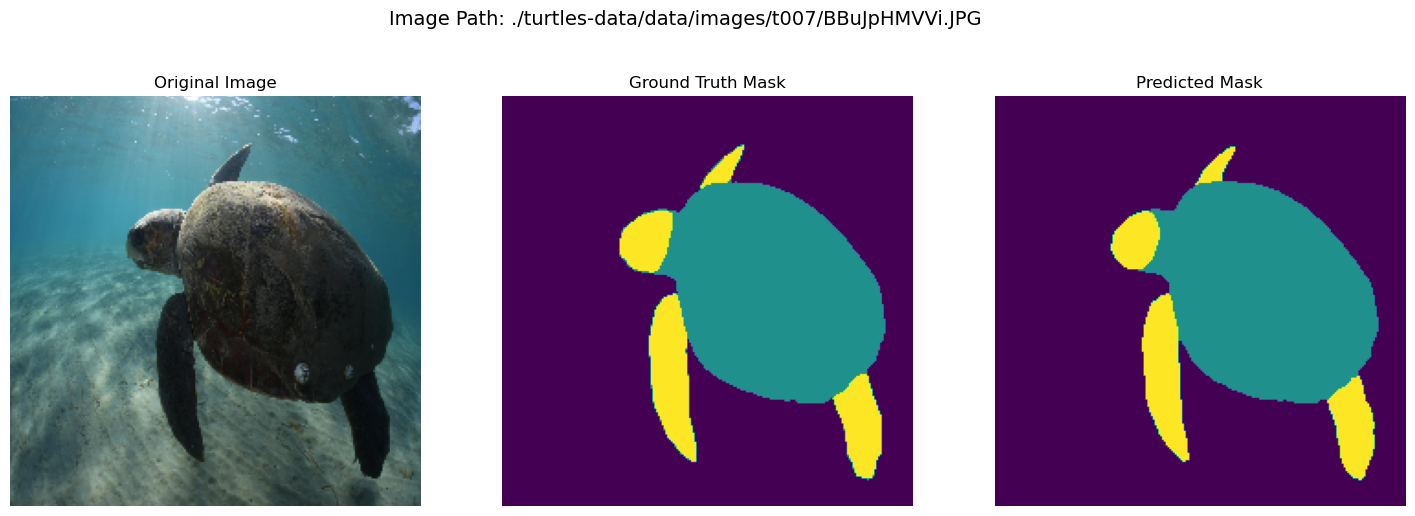

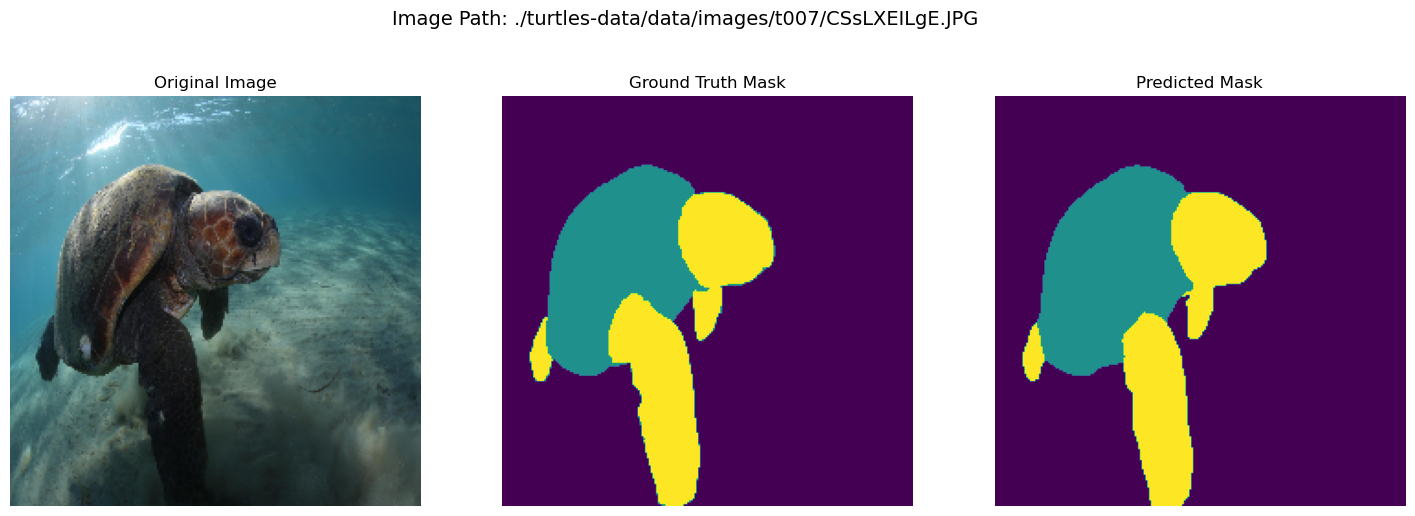

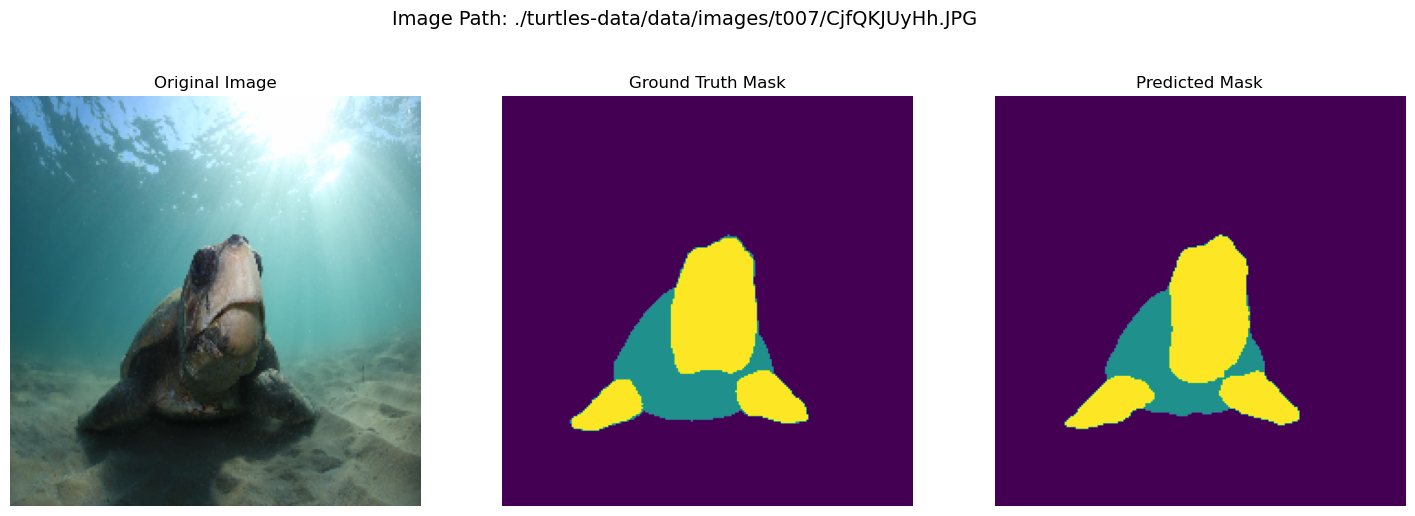

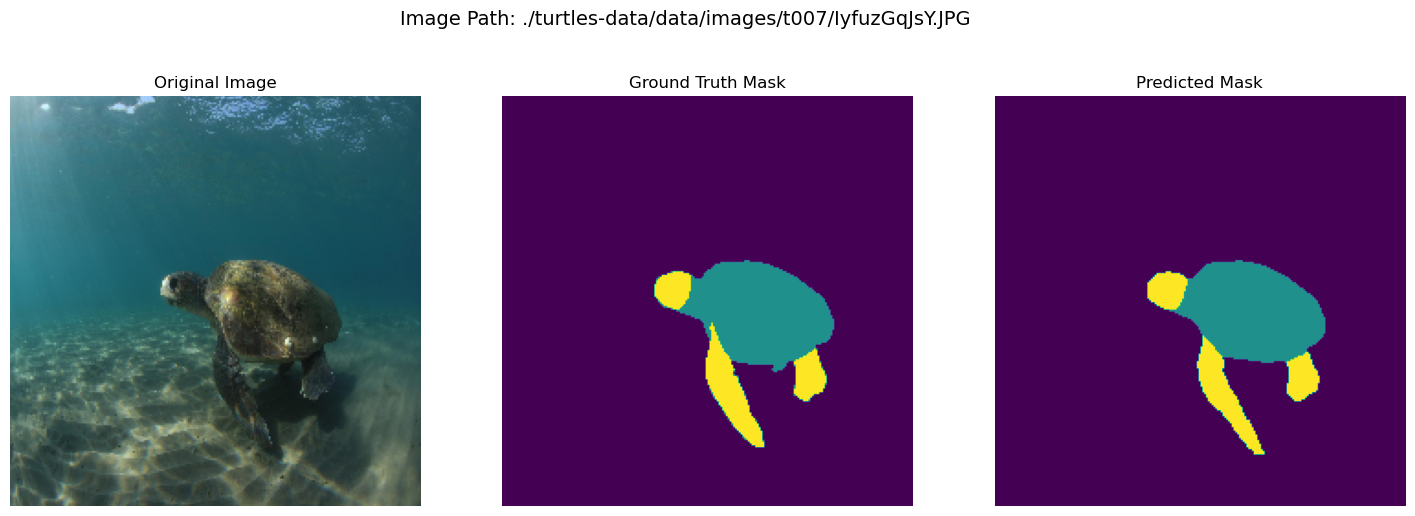

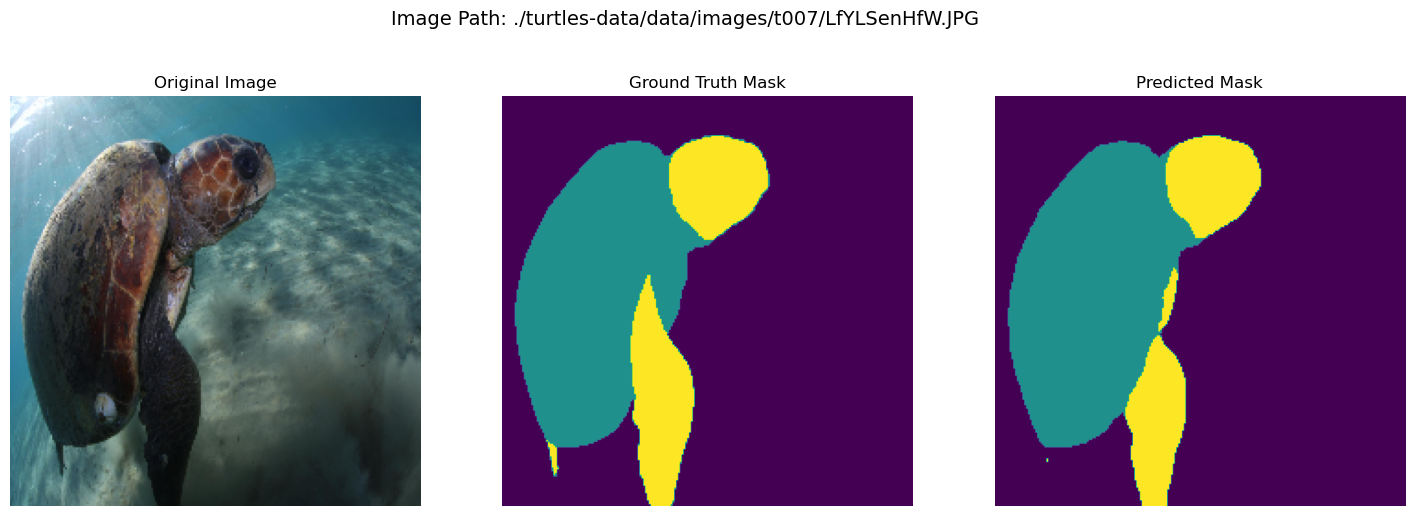

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# denormalize for display
def denormalize(image, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean  
    image = np.clip(image, 0, 1)  
    return image

def display_predictions(model, test_loader, device, num_images=5):
    model.eval()
    images_shown = 0
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    with torch.no_grad():
        for images, masks, paths in test_loader: 
            images = images.to(device)
            # Truth ground mask
            masks = masks.cpu().numpy()  
            
            # model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy() 

            # display demonstrate
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return 
                
                # image tensor to a numpy array
                image = images[i].cpu().numpy().transpose(1, 2, 0) 
                image = denormalize(image, mean, std) 
                
                mask = masks[i]
                pred_mask = preds[i]
                image_path = paths[i]

                # Display the results
                fig, axs = plt.subplots(1, 3, figsize=(18, 6))
                fig.suptitle(f"Image Path: {image_path}", fontsize=14)

                axs[0].imshow(image)
                axs[0].set_title("Original Image")
                axs[0].axis("off")

                axs[1].imshow(mask, cmap="viridis")
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis("off")

                axs[2].imshow(pred_mask, cmap="viridis")
                axs[2].set_title("Predicted Mask")
                axs[2].axis("off")

                plt.show()
                images_shown += 1


display_predictions(model, test_loader, device)
